<a href="https://colab.research.google.com/github/raheelam98/langgraph_guru/blob/main/llm_ai_agents/2_conversational_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Conversational Agent**

* OPENAI_API_KEY=sk- your key
* GEMINI_API_KEY= your key
* LANGCHAIN_API_KEY=ls your key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_PROJECT=project name

Use either **`OPENAI_API_KEY`** or **`GEMINI_API_KEY`**

In poetry add these packages


poetry add python-dotenv black isort langchain langchain-openai langgraph langchain_google_genai

In [25]:
# Install the required packages:
%%capture --no-stderr
%pip install --quiet -U langgraph  langchain  langchain_google_genai python-dotenv

In [26]:
# API Keys
# Get the GEMINI API key from user data
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

We'll use [LangSmith](https://docs.smith.langchain.com/) for
[tracing](https://docs.smith.langchain.com/concepts/tracing).

In [27]:
from google.colab import userdata
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')

In [28]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "agentic_chatbot"

In [50]:
# Initialize the language model
# Initialize the ChatGoogleGenerativeAI with the Gemini model

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",  # Specify the model to use
    max_retries=2,
    api_key=gemini_api_key    # Provide the Google API key for authentication
)

In [51]:
# Invoke the LLM with a query
res = llm.invoke("hi")
print(res)

content='Hi there! How can I help you today?\n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-f935690c-b857-480c-bfd3-da350ddc7f4d-0' usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}}


## **Converstion Flow**

**Prompt** to predict, review the output, revise it, and provide suggestions for improvement

In [54]:
# creating the reflector chain and the tweet reviosr chain
# Prompt to predict, review the output, revise it, and provide suggestions for improvement

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_openai import ChatOpenAI

# from dotenv import load_dotenv

# #Load environment variables from .env file
# # load_dotenv()

In [57]:
# Prompt to predict, review the output, revise it, and provide suggestions for improvement
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a viral twitter influencer grading a tweet. Generate critique and recommendation for the user."
            "Always provide detailed recommendations, including requests for length, virality, style, etc."
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)

In [58]:
# Generate a message and continuously revise it based on feedback
# from the reflection prompt until achieve the perfect result.
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
           "system",
           "You are a twitter techie influencer assistant tasked with writing excellent twitter posts."
           "Generate the best twitter post possible for the user's request."
           "If the user provides critique, respond with a revised version of your previous attempts."
        ),
        # placehoder for reflection and revision
        MessagesPlaceholder(variable_name="messages")
    ]
)

**Connect Prompt to LLM and Create Chain**

In [59]:
# Connect Prompt to LLM and Create Chain

# Create the generation chain by combining the generation prompt with the language model.
generation_chain = generation_prompt | llm

# Create the reflection chain by combining the reflection prompt with the language model.
reflection_chain = reflection_prompt | llm


**Create Graph for Converstion Flow**

In [61]:
from typing import List, Sequence

# from dotenv import load_dotenv

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph


**Define Nodes**

In [62]:
# define nodes name
REFLECT = "reflect"
GENERATE = "generate"

### Conversation Flow (Part 1)

**Input Messages**

The **generate node receives an input state**, where the state is a sequence of messages. It runs the generation chain and invokes all the states, essentially taking a tweet and revising it according to the state.

In [63]:
# Define the generation node function which receives an input
# state (a sequence of messages).
def generation_node(state: Sequence[BaseMessage]):
    # Invoke the generation chain with the current state,
    # where state is passed as a dictionary with "messages" as the key.
    return generation_chain.invoke({"messages": state})


### Conversation Flow (Part 2)

**Receive Messages**

Once it **receives a sequence of messages and invokes the chain**, as in the generation node:

Difference in this function:

* The response comes back from the LLM (usually in the role of AI).

* We transform this response into a human message.

* Take the content from the message and treat it as if a human sent it.

* Train the message with the role of a human and then return it.

**Reason :** By treating the LLM as if it were a human sending these messages, we maintain the conversation flow.

In [64]:
# Define the reflection node function which receives a sequence of messages.
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Invoke the reflection chain with the current messages,
    # where messages are passed as a dictionary with "messages" as the key.
    res = reflection_chain.invoke({"messages": messages})

    # Return the response as a list containing HumanMessage,
    # transforming the content from the LLM's response into a human message.
    return [HumanMessage(content=res.content)]


**Create a Graph to Process up to 6 Messages**

In [65]:
# Initialize the MessageGraph builder
builder: MessageGraph = MessageGraph()

# Add the generate node to the graph
builder.add_node(GENERATE, generation_node)

# Add the reflect node to the graph
builder.add_node(REFLECT, reflection_node)

# Set the entry point of the graph to the generate node (commented out alternative version)
# builder.set_entry_point(generation_node)

# Set the entry point of the graph to the generate node using the node name
builder.set_entry_point(GENERATE)

# Define a function to determine if the process should continue
def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        return END
    return REFLECT

# Add conditional edges from the generate node based on the should_continue function
builder.add_conditional_edges(GENERATE, should_continue)

# Add an edge from the reflect node back to the generate node
builder.add_edge(REFLECT, GENERATE)

# Compile the graph
graph = builder.compile()

In [66]:
# Print the graph representation in Mermaid syntax
print(graph.get_graph().draw_mermaid())

# Main entry point
if __name__ == '__main__':
    print("hi LangGraph")


%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	generate(generate)
	reflect(reflect)
	__end__([<p>__end__</p>]):::last
	__start__ --> generate;
	reflect --> generate;
	generate -.-> reflect;
	generate -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

hi LangGraph


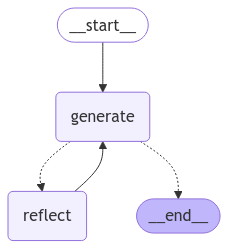

In [67]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))